In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from ema_workbench import (
    ScalarOutcome,
    load_results,
    Policy,
    MultiprocessingEvaluator
)
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging, utilities

from sklearn.preprocessing import MinMaxScaler

from custom_problem_formulation_no_RfR import get_model_for_problem_formulation

In [3]:
# Load policies from the CSV file
policies_df = pd.read_csv('results/50_diverse_policies.csv')

# Drop unwanted columns
policies_df = policies_df.drop(columns=[
    'A.1_External Costs',
    'A.1_Expected Number of Deaths',
    'A.1_Expected Annual Damage',
    'A.2_External Costs',
    'A.2_Expected Number of Deaths',
    'A.2_Expected Annual Damage',
    'composite_ooi',
    'satisfied'
])

# Create a new column with the desired format
policies_df['index'] = 'scenario' + policies_df['scenario'].astype(str) + '_policy' + policies_df['Unnamed: 0'].astype(str)

# Set the new column as the index
policies_df.set_index('index', inplace=True)

# Drop the original 'scenario' and 'unnamed: 0' columns
policies_df = policies_df.drop(columns=['scenario', 'Unnamed: 0'])

policies_df.head()


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
index,,,,,,,,,,,,,,,,,,,,,
scenario48226_policy61,0,0,0,0,1,1,1,1,1,1,...,0,5,5,1,7,0,4,0,6,7
scenario5666_policy117,0,0,1,0,0,0,1,1,1,1,...,0,4,4,0,5,0,4,5,0,0
scenario5666_policy138,0,0,0,1,0,0,1,1,1,1,...,0,5,7,7,6,2,7,4,0,5
scenario5666_policy143,1,0,0,0,0,0,1,1,1,1,...,0,5,5,6,4,5,8,7,0,3
scenario5666_policy132,0,0,0,0,1,0,1,1,1,1,...,0,1,2,5,6,9,0,3,7,1


In [4]:
policies = []
for idx, row in policies_df.iterrows():
    policy_dict = row.to_dict()
    policy_name = idx
    policies.append(Policy(policy_name, **policy_dict))

model, steps = get_model_for_problem_formulation()

# Define the number of scenarios
n_scenarios = 1000

# Perform experiments
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies)

experiments, outcomes = results

/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decision_Making_Env/lib/python3.12/site-packages/ema_workbench/em_framework/__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
/Users/wouter/.pyenv/versions/3.12.2/envs/EPA141A_Model_Based_Decis

In [6]:
# Saving the results
utilities.save_results(results, 'results/50_policies_1000_scenarios.tar.gz')

In [77]:
# Load the results
results = utilities.load_results('results/50_policies_1000_scenarios.tar.gz')

experiments, outcomes = results

outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
policies_50_results = outcomes.join(experiments)

In [78]:
# Function to calculate SNR metric
def calculate_snr(policy, direction):
  mean_performance = np.mean(policy)
  std_dev = np.std(policy)
  
  if direction == ScalarOutcome.MINIMIZE:
      snr = mean_performance * std_dev
  else:
      snr = mean_performance / std_dev
  return snr


In [79]:
# Initialize an empty list to store all SNR scores
snr_scores = []

# Iterate over each policy in the experiments DataFrame
for policy in experiments['policy'].unique():
    # Initialize a dictionary to store SNR scores for the current policy
    scores = {'policy': policy}
    
    # Filter experiments DataFrame to get rows where 'policy' matches the current policy
    logical = experiments['policy'] == policy
    
    # Iterate over each outcome in the model.outcomes list (replace with your actual outcomes)
    for outcome in model.outcomes:
        # Extract values from the experiments DataFrame where the logical condition is True
        value = outcomes[outcome.name][logical]
        
        # Calculate the signal-to-noise ratio (SNR) for the extracted values
        sn_ratio = calculate_snr(value, outcome.kind)
        
        # Store the SNR score in the scores dictionary with outcome name as key
        scores[outcome.name] = sn_ratio
    
    # Append the scores dictionary to the snr_scores list
    snr_scores.append(scores)

# Convert the list of dictionaries to a DataFrame
snr_scores_df = pd.DataFrame(snr_scores)

# Set policy column as
snr_scores_df.set_index('policy', inplace=True)

In [81]:
snr_scores_df

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage
policy,,,,,,
scenario48226_policy61,0.495516,0.000103,1.795914e+16,0.000000,4.458828e-07,3.533768e+13
scenario5666_policy117,0.277573,0.000626,1.024486e+17,0.000000,3.451979e-07,2.813842e+13
scenario5666_policy138,0.000000,0.000935,1.534418e+17,0.000000,3.764305e-07,3.038584e+13
scenario5666_policy143,1.061308,0.000262,4.394700e+16,0.000000,1.670880e-06,1.404912e+14
scenario5666_policy132,0.495516,0.000717,1.199669e+17,0.984149,7.692214e-08,5.935344e+12
scenario5666_policy91,0.000000,0.000448,7.424763e+16,0.984149,8.817097e-08,6.638484e+12
scenario24626_policy72,0.000000,0.001286,2.083302e+17,0.984149,5.234578e-08,4.200059e+12
scenario5666_policy150,0.000000,0.000241,4.038459e+16,0.000000,1.740643e-08,1.254401e+12
scenario48226_policy3,0.000000,0.000281,4.723850e+16,0.984149,8.956806e-08,6.733059e+12


It makes sense that for both A.1_External Costs and A.2_External Costs the snr ratio is 0 most of the times. This is due to the fact that we defined 'External Costs' as the sum of dike investment costs and evacuation costs. Both of these costs depend completely and mostly on policy levers respectively. Because the policy levers stay the same for all 1000 experiments that the policy is tested, it returns the same result every time, as a result of this the standard deviation is 0. Given the way the signal-to-noise ratio is calculated this will thus result in a value of 0 as well.

In [116]:
#Creating a composite snr score so we can select the 20 best policies, we value each outcome of interest equally

scaler = MinMaxScaler()
normalized_snr = scaler.fit_transform(snr_scores_df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 'A.1_External Costs',
                                                   'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths', 'A.2_External Costs']])
composite_snr = normalized_snr.sum(axis=1)
snr_scores_df['composite_snr'] = composite_snr 

# Dropping the 30 worst policies based on composite_snr score
snr_scores_df_top_20 = snr_scores_df.drop(snr_scores_df['composite_snr'].nlargest(30).index)

In [117]:
snr_scores_df_top_20

,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_snr
policy,,,,,,,
scenario48226_policy61,0.495516,0.000103,1.795914e+16,0.000000,4.458828e-07,3.533768e+13,0.256292
scenario5666_policy143,1.061308,0.000262,4.394700e+16,0.000000,1.670880e-06,1.404912e+14,0.766914
scenario5666_policy150,0.000000,0.000241,4.038459e+16,0.000000,1.740643e-08,1.254401e+12,0.297590
scenario48226_policy62,1.148879,0.000099,1.658653e+16,0.000000,4.444831e-07,3.524733e+13,0.462523
scenario48226_policy13,0.277573,0.000131,2.190856e+16,0.000000,1.735888e-06,1.454912e+14,0.292462
scenario5666_policy103,0.000000,0.000060,1.075026e+16,0.000000,1.762596e-06,1.474361e+14,0.087784
scenario48226_policy2,0.000000,0.000060,1.075026e+16,0.984149,9.594215e-08,7.198975e+12,0.816994
scenario48226_policy9,0.000000,0.000200,3.377231e+16,0.000000,4.389536e-07,3.487784e+13,0.251964
scenario48226_policy8,0.000000,0.000077,1.383416e+16,0.000000,1.758486e-06,1.471586e+14,0.117104


/var/folders/mz/j0q1_7_x2f59p13bv_c81xhc0000gn/T/ipykernel_20948/3726142043.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))


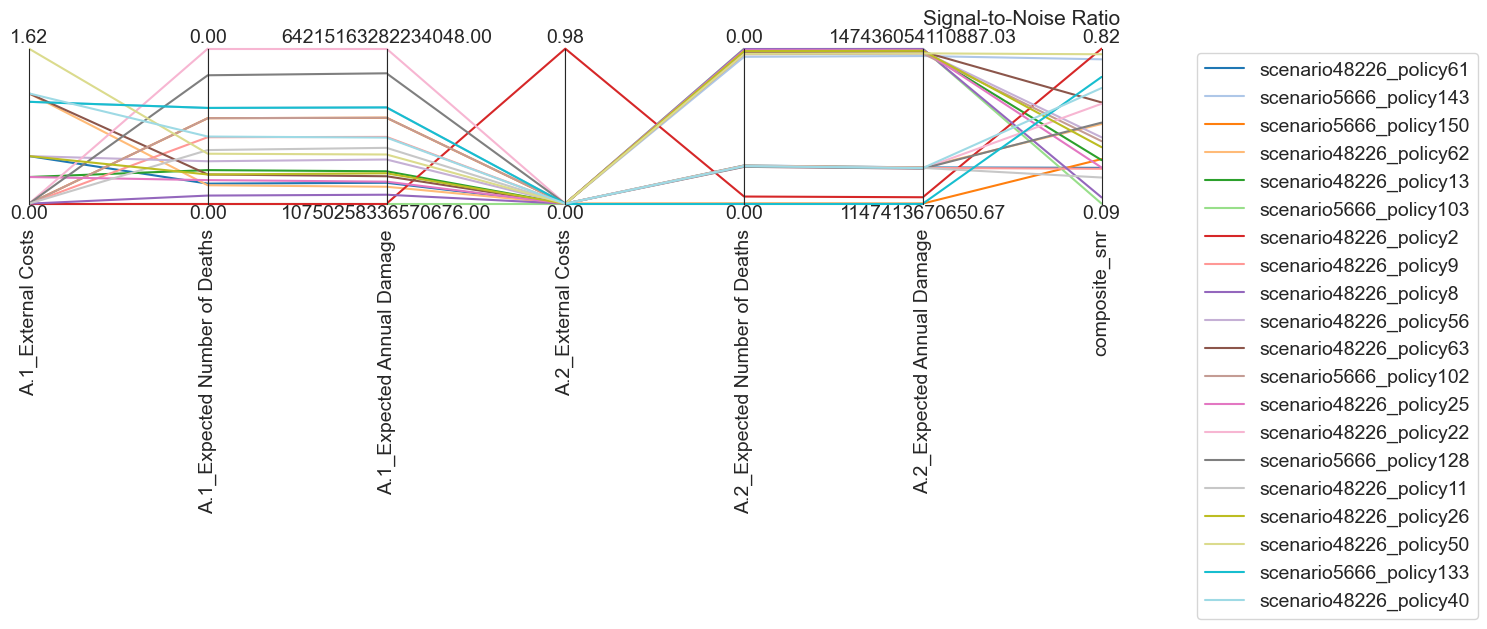

In [119]:
import matplotlib.cm as cm

# Create a colormap
cmap = cm.get_cmap('tab20', len(snr_scores_df_top_20.index.unique()))

# Get the limits for the plot
limits = parcoords.get_limits(snr_scores_df_top_20)

# Create a parallel axes plot
paraxes = parcoords.ParallelAxes(limits)

for i, policy in enumerate(snr_scores_df_top_20.index.unique()):
    data = pd.DataFrame(snr_scores_df_top_20.loc[policy]).transpose()
    paraxes.plot(data, color=cmap(i), label=policy)

paraxes.legend()
fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.title('Signal-to-Noise Ratio', loc='left', fontsize=15)
plt.savefig('images/snr_top20.png')
plt.show()